# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import numpy as np
# nltk.download('all')

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 30
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in tqdm(range(1, pages + 1)):

    #print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    #print(f"   ---> {len(reviews)} total reviews")

100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Another awful experience b...
1,"✅ Trip Verified | The service was rude, full..."
2,✅ Trip Verified | This flight was a joke. Th...
3,✅ Trip Verified | This time British Airways ...
4,"✅ Trip Verified | The seats were excellent, ..."


In [4]:

print(df.head())

def preclean_text(dataframe: pd.core.frame.DataFrame, column: str):
    if type(dataframe[column][0]) is str:
        for i in range(len(dataframe[column])):
            rowtext = dataframe.loc[i, column]
            if rowtext[0] == "\u2705":
                #print(df.loc[i, 'reviews'])
                dataframe.loc[i, column] = rowtext[rowtext.find("|") + 1:]
                #print(df.loc[i, 'reviews'])
                rowtext = dataframe.loc[i, column]
                while rowtext[0] == " ":
                    dataframe.loc[i, column] = dataframe.loc[i, column][1:]
                    rowtext = dataframe.loc[i, column]
                #print(df.loc[i, 'reviews'])

preclean_text(df, 'reviews')


print(df.head())

##df.to_csv("data/BA_reviews.csv")

                                             reviews
0  ✅ Trip Verified |   Another awful experience b...
1  ✅ Trip Verified |   The service was rude, full...
2  ✅ Trip Verified |   This flight was a joke. Th...
3  ✅ Trip Verified |   This time British Airways ...
4  ✅ Trip Verified |   The seats were excellent, ...
                                             reviews
0  Another awful experience by British Airways. T...
1  The service was rude, full of attitude to me, ...
2  This flight was a joke. There was four people ...
3     This time British Airways managed to get ev...
4  The seats were excellent, with a feel of much ...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

print(df.head())

df['reviews_tokenized'] = df['reviews'].apply(preprocess_text)
print(df.head())

                                             reviews
0  Another awful experience by British Airways. T...
1  The service was rude, full of attitude to me, ...
2  This flight was a joke. There was four people ...
3     This time British Airways managed to get ev...
4  The seats were excellent, with a feel of much ...
                                             reviews  \
0  Another awful experience by British Airways. T...   
1  The service was rude, full of attitude to me, ...   
2  This flight was a joke. There was four people ...   
3     This time British Airways managed to get ev...   
4  The seats were excellent, with a feel of much ...   

                                   reviews_tokenized  
0  another awful experience british airway . flig...  
1  service rude , full attitude , food poorly ser...  
2  flight joke . four people business class inclu...  
3  time british airway managed get everything rig...  
4  seat excellent , feel much room official seat ...  


In [9]:
### Using the nltk Sentiment Analyzer led to obvious incorrect classifications so instead OpenAI was used.
from openai import OpenAI
with open("F:/Berkeley/Forage/secrets.txt") as f:
    client = OpenAI(api_key=f.readline())

def get_sentiment(text):
    completion = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content": "You are evaluating the sentiment analysis of a piece of text"},
                        {"role": "user", "content": f"Calculate the sentiment of this text on a scale from 1 (very positive) to -1 (very negative): {text}. Answer with one number"}
                    ]
                )
    return completion.choices[0].message.content

# print(df.head())
# df['sentiments'] = df['reviews_tokenized'].apply(get_sentiment)
print(df.head())
#df.to_csv("../Forage/data/BA_with_raw_sentiment.csv")

                                             reviews  \
0  Another awful experience by British Airways. T...   
1  The service was rude, full of attitude to me, ...   
2  This flight was a joke. There was four people ...   
3     This time British Airways managed to get ev...   
4  The seats were excellent, with a feel of much ...   

                                   reviews_tokenized  
0  another awful experience british airway . flig...  
1  service rude , full attitude , food poorly ser...  
2  flight joke . four people business class inclu...  
3  time british airway managed get everything rig...  
4  seat excellent , feel much room official seat ...  


In [10]:
df = pd.read_csv("BA_with_raw_sentiment.csv")
print(df.head())
def sentiment_cleaning(dataframe: pd.core.frame.DataFrame, column: str):
    for i in range(len(dataframe[column])):
            rowtext = dataframe.loc[i, column]
            beginning = rowtext.find("-0.")
            if beginning == -1:
                beginning = rowtext.find("0.")
            if beginning == -1:
                beginning = rowtext.find("-1")
            num = rowtext[beginning: beginning + 5]
            while not num[-1].isdigit():
                num = num[:-1]
            dataframe.loc[i, column] = float(num)

sentiment_cleaning(df, 'sentiments')
print(df.head())

   Unnamed: 0                                            reviews  \
0           0  recent flight cyprus ba621 23/11/24 , second c...   
1           1  flight ba 0560 arrived rome 11 december passen...   
2           2  first time flew british airway , huge disappoi...   
3           3  pretty good flight still small thing improved ...   
4           4  check fine , priority/fast track line security...   

                                          sentiments  
0                                               -0.8  
1  Based on the text provided, the sentiment woul...  
2  The sentiment of the text can be calculated as...  
3                                                0.6  
4                                               -0.2  
   Unnamed: 0                                            reviews sentiments
0           0  recent flight cyprus ba621 23/11/24 , second c...       -0.8
1           1  flight ba 0560 arrived rome 11 december passen...       -0.9
2           2  first time flew br

0.6423333333333333


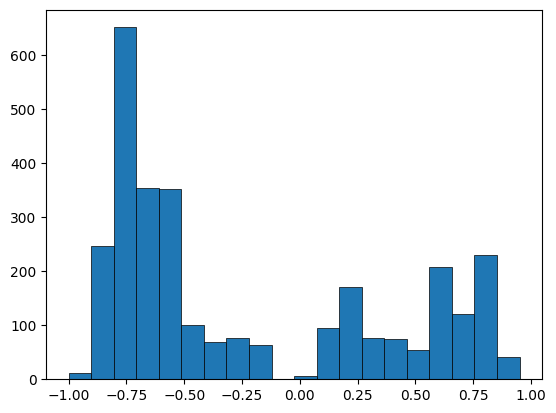

In [221]:
fig, ax = plt.subplots()
ax.hist(df['sentiments'], bins = 20, linewidth=0.5, edgecolor="black")
plt.savefig("BA_Sentiment_Histogram.png")

negative_percent = len([i for i in range(len(df["sentiments"])) if df.loc[i,"sentiments"] < 0])/len(df["sentiments"])
print(negative_percent)

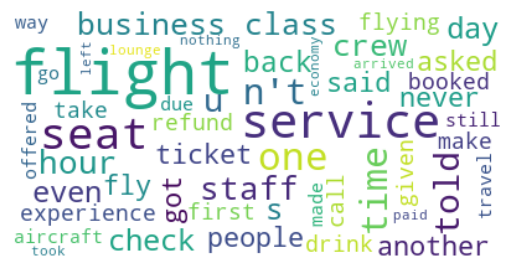

In [11]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
stopwords.update(["ba", "cabin", "meal", "british", "airway", "london heathrow", "heathrow", "airport", "luggage", "london", "airline", "plane", "passenger", "food", "customer", "bag"])

all_text = " ".join(df.loc[i, "reviews"] for i in range(len(df['reviews'])) if df.loc[i, "sentiments"] < -0.75)

all_wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=50, background_color="white").generate(all_text)
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("BA_wordcloud.png")